# Set Environment

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [2]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Load Data

In [3]:
import pickle
from tensorflow.keras.utils import to_categorical


# Define class names
class_names = ['Unidentifiable', 'Type 1', 'Type 2', 'Type 3']

# Load data splits using pickle
print('Loading data splits ...')
with open('/kaggle/input/create-folds/folds.pkl', 'rb') as f:
    folds = pickle.load(f)

# Extract the splits
X1, X2, X3, X4, X5 = folds['X1'], folds['X2'], folds['X3'], folds['X4'], folds['X5']
y1, y2, y3, y4, y5 = folds['y1'], folds['y2'], folds['y3'], folds['y4'], folds['y5']

# Define the input shape (assuming all splits have the same input shape)
input_shape = X1[0].shape

# Number of classes
num_classes = len(class_names)

# Image size
image_size = (256, 256)

# Apply one-hot encoding to the labels
y1_encoded = to_categorical(y1, num_classes=num_classes)
y2_encoded = to_categorical(y2, num_classes=num_classes)
y3_encoded = to_categorical(y3, num_classes=num_classes)
y4_encoded = to_categorical(y4, num_classes=num_classes)
y5_encoded = to_categorical(y5, num_classes=num_classes)

print("Data splits loaded and one-hot encoded successfully.")

# Print summary of splits
splits = [(X1, y1_encoded), (X2, y2_encoded), (X3, y3_encoded), (X4, y4_encoded), (X5, y5_encoded)]
for i, (X_split, y_split) in enumerate(splits, start=1):
    print(f"Split {i}:")
    print(f"  X shape: {X_split.shape}")
    print(f"  y shape: {y_split.shape}")
    class_counts = np.bincount(np.argmax(y_split, axis=1))
    for class_idx, count in enumerate(class_counts):
        print(f'  Class {class_names[class_idx]}: {count} samples')

Loading data splits ...
Data splits loaded and one-hot encoded successfully.
Split 1:
  X shape: (1623, 256, 256, 3)
  y shape: (1623, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 218 samples
  Class Type 2: 565 samples
  Class Type 3: 271 samples
Split 2:
  X shape: (1623, 256, 256, 3)
  y shape: (1623, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 218 samples
  Class Type 2: 565 samples
  Class Type 3: 271 samples
Split 3:
  X shape: (1621, 256, 256, 3)
  y shape: (1621, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 217 samples
  Class Type 2: 564 samples
  Class Type 3: 271 samples
Split 4:
  X shape: (1621, 256, 256, 3)
  y shape: (1621, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 217 samples
  Class Type 2: 564 samples
  Class Type 3: 271 samples
Split 5:
  X shape: (1620, 256, 256, 3)
  y shape: (1620, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 217 samples
  Class Type 2: 564 samples
  Class Type 3: 270 samples


# Train-Validation-Test Set

In [4]:
from sklearn.model_selection import train_test_split


set_seed()

# Concatenate X2 to X5 into x_train and y2 to y5 into y_train
x_train = np.concatenate((X2, X3, X4, X1), axis=0)
y_train = np.concatenate((y2_encoded, y3_encoded, y4_encoded, y1_encoded), axis=0)

# Set X1 as x_test and y1 as y_test
x_test = X5
y_test = y5_encoded

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Oversampling

In [5]:
import gc
from imblearn.over_sampling import SMOTE
from collections import Counter


set_seed()

# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

y_train_before_smote = y_train

# Initialize SMOTE
smote = SMOTE(random_state=2119)

# Reshape the data for oversampling
X_reshaped = x_train.reshape(-1, image_size[0] * image_size[1] * 3)

# Apply oversampling
X_resampled, y_resampled = smote.fit_resample(X_reshaped, np.argmax(y_train, axis=1))

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

# Reshape the data back to the original shape
X_resampled = X_resampled.reshape(-1, image_size[0], image_size[1], 3)

x_train = X_resampled
y_train = to_categorical(y_resampled, num_classes=num_classes)
    
del X_resampled
del y_resampled

# Calculate class distribution after oversampling
resampled_class_distribution = Counter(np.argmax(y_train, axis=1).tolist())
print("Class distribution after oversampling:", resampled_class_distribution)

print(f'Total Number of Samples after Oversampling: {len(y_train)+len(y_val)+len(y_test)}')
print(f'Samples in Train Set: {len(y_train)}')
print(f'Samples in Validation Set: {len(y_val)}')
print(f'Samples in Test Set: {len(y_test)}')

Freeing up memory!
Shape of X_resampled: (7356, 196608)
Shape of y_resampled: (7356,)
Class distribution after oversampling: Counter({2: 1839, 0: 1839, 1: 1839, 3: 1839})
Total Number of Samples after Oversampling: 10274
Samples in Train Set: 7356
Samples in Validation Set: 1298
Samples in Test Set: 1620


# Oersampling plot

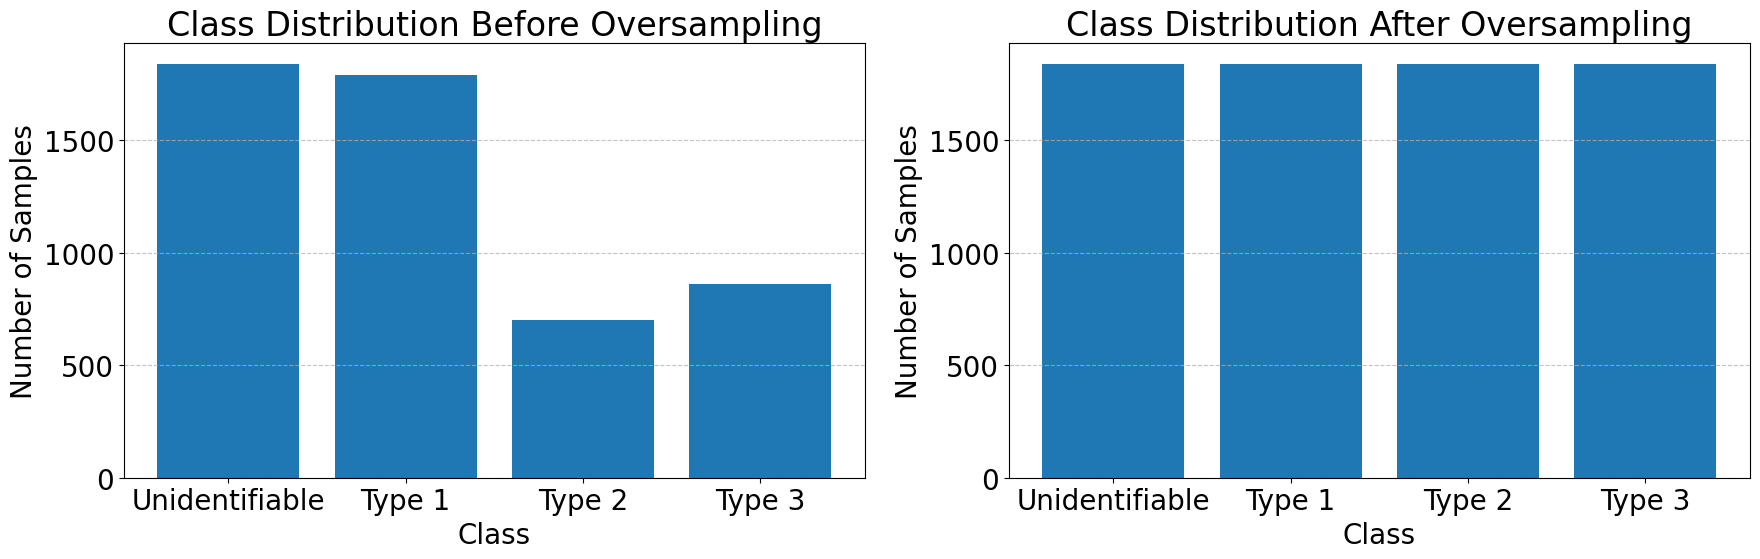

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


# Function to plot class distributions side by side
def plot_class_distributions(y_before, y_after, class_names, filename):
    # Calculate class distributions
    class_counts_before = Counter(np.argmax(y_before, axis=1).tolist())
    class_counts_after = Counter(np.argmax(y_after, axis=1).tolist())

    # Set font to Computer Modern Roman and size to 11
    plt.rc('font', family='CMR', size=20)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot histogram before oversampling
    axes[0].bar(class_names, list(class_counts_before.values()))
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Class Distribution Before Oversampling')
    axes[0].grid(axis='y', linestyle='--', alpha=0.75)

    # Plot histogram after oversampling
    axes[1].bar(class_names, list(class_counts_after.values()))
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Number of Samples')
    axes[1].set_title('Class Distribution After Oversampling')
    axes[1].grid(axis='y', linestyle='--', alpha=0.75)

    # Adjust layout
    plt.tight_layout()

    # Save the figure in high resolution
    plt.savefig(filename, dpi=600)

    # Show the plots
    plt.show()

# Example usage: Assuming y_train_before_smote and y_train are defined
# Replace y_train_before_smote and y_train with actual variables containing the data
# Generate histograms for class distributions before and after oversampling
plot_class_distributions(y_train_before_smote, y_train, class_names, 'class_distributions.png')

# Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter


# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=90,  # Rotate images randomly between -90 and 90 degrees
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True  # Randomly flip images vertically
)

set_seed()

# Define the proportion of data to augment
augmentation_proportion = 0.8  # For example, augment 50% of the data

# Determine the number of samples to augment
num_samples_to_augment = int(len(x_train) * augmentation_proportion)

# Randomly select samples to augment
indices_to_augment = np.random.choice(len(x_train), num_samples_to_augment, replace=False)

# Augment the selected samples
x_augmented = []
y_augmented = []
for idx in indices_to_augment:
    image = x_train[idx]
    label = y_train[idx]
    # Apply augmentation
    augmented_images = datagen.flow(np.expand_dims(image, axis=0), np.expand_dims(label, axis=0), batch_size=1)
    for _ in range(2):  # Augment each sample twice
        augmented_image, augmented_label = next(augmented_images)
        x_augmented.append(augmented_image.squeeze())
        y_augmented.append(augmented_label.squeeze())

# Convert lists to arrays
x_augmented = np.array(x_augmented)
y_augmented = np.array(y_augmented)

# Concatenate augmented data with original data
x_train_augmented = np.concatenate([x_train, x_augmented])
y_train_augmented = np.concatenate([y_train, y_augmented])

# Print statements
print(f"Original x_train shape: {x_train.shape}")
print(f"Original y_train shape: {y_train.shape}")

print(f"Number of samples to augment: {num_samples_to_augment}")
print(f"x_augmented shape: {x_augmented.shape}")
print(f"y_augmented shape: {y_augmented.shape}")

print(f"Augmented x_train shape: {x_train_augmented.shape}")
print(f"Augmented y_train shape: {y_train_augmented.shape}")

# Verify class distribution in augmented data
augmented_class_distribution = Counter(np.argmax(y_train_augmented, axis=1).tolist())
print("Class distribution after augmentation:", augmented_class_distribution)